In [ ]:
import os
import anthropic
import json

# Initialize the client (reads ANTHROPIC_API_KEY from environment)
try:
    client = anthropic.Anthropic()

    prompt = """
    Generate a single synthetic WIMP event as a JSON object.
    The event should have keys: 's1_photons', 's2_charge', and 'recoil_energy_keV'.
    Ensure the values are physically plausible for a low-energy nuclear recoil in a liquid xenon detector.
    For example, s1 should be small (typically 5-50 photons for low-energy nuclear recoils), 
    and s2 should be relatively low for that s1 (roughly 100-2000 electrons).
    Recoil energy should typically be in the range of 1-50 keV for WIMP searches.
    
    CRITICAL: Respond with ONLY a valid JSON object. No markdown, no code blocks, no extra text.
    Format: {"s1_photons": <number>, "s2_charge": <number>, "recoil_energy_keV": <number>}
    """

    message = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=256,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    # Extract response text
    response_text = message.content[0].text.strip()
    print("Raw Response from Claude:")
    print(response_text)

    # Clean up potential markdown formatting (just in case)
    if response_text.startswith("```"):
        # Remove markdown code blocks if present
        response_text = response_text.replace("```json", "").replace("```", "").strip()

    # Attempt to parse the JSON
    try:
        event_data = json.loads(response_text)
        print("\nSuccessfully parsed JSON:")
        print(json.dumps(event_data, indent=2))
        
        # Validate the expected keys are present
        required_keys = ['s1_photons', 's2_charge', 'recoil_energy_keV']
        if all(key in event_data for key in required_keys):
            print("\n✅ API connection and JSON output confirmed.")
            print(f"   S1: {event_data['s1_photons']} photons")
            print(f"   S2: {event_data['s2_charge']} electrons")
            print(f"   Energy: {event_data['recoil_energy_keV']} keV")
        else:
            print(f"\n⚠️ Warning: Missing expected keys. Got: {list(event_data.keys())}")
            
    except json.JSONDecodeError as je:
        print(f"\n⚠️ JSON Parse Error: {je}")
        print("Response may contain extra text or formatting.")

except anthropic.APIError as api_err:
    print(f"❌ API Error: {api_err}")
except Exception as e:
    print(f"❌ An error occurred: {e}")
    print("Please check your API key and environment setup.")

In [64]:
import pandas as pd
import numpy as np
import os

def generate_correlated_events(n_events, mean_s1, mean_s2, s1_std, s2_std, correlation):
    """
    Generates correlated S1 and S2 events using a multivariate normal distribution.
    """
    mean = [mean_s1, mean_s2]
    cov_s1_s2 = correlation * s1_std * s2_std
    cov_matrix = [[s1_std**2, cov_s1_s2], [cov_s1_s2, s2_std**2]]
    
    events = np.random.multivariate_normal(mean, cov_matrix, n_events)
    events[events < 0] = 0  # Enforce physical constraint (no negative signals)
    return events

def generate_dataset(num_events=500, signal_fraction=0.2):
    """
    Generates a full dataset of mixed Nuclear Recoil (NR) and Electronic Recoil (ER) events.
    Adds 'confidence' and 's2_photons' columns.
    """
    n_signal = int(num_events * signal_fraction)
    n_background = num_events - n_signal

    events_list = []

    # --- Nuclear Recoil (NR) events ---
    nr_energies = np.random.exponential(scale=5.0, size=n_signal) + 2.0
    for energy in nr_energies:
        mean_s1 = energy * 2.0
        mean_s2 = energy * 50.0
        s1_std = np.sqrt(mean_s1) * 0.5
        s2_std = np.sqrt(mean_s2) * 0.5
        correlation = -0.6

        s1, s2_charge = generate_correlated_events(1, mean_s1, mean_s2, s1_std, s2_std, correlation)[0]
        s2_photons = s2_charge * np.random.uniform(0.8, 1.2)  # Random conversion to photon counts

        events_list.append({
            'true_label': 'Nuclear Recoil',
            'recoil_energy_keV': energy,
            's1_photons': s1,
            's2_charge': s2_charge,
            's2_photons': s2_photons,
            'confidence': np.random.uniform(0.7, 1.0)  # High confidence for NR
        })

    # --- Electronic Recoil (ER) events ---
    er_energies = np.random.uniform(low=2.0, high=50.0, size=n_background)
    for energy in er_energies:
        mean_s1 = energy * 1.5
        mean_s2 = energy * 200.0
        s1_std = np.sqrt(mean_s1) * 0.7
        s2_std = np.sqrt(mean_s2) * 0.7
        correlation = -0.4

        s1, s2_charge = generate_correlated_events(1, mean_s1, mean_s2, s1_std, s2_std, correlation)[0]
        s2_photons = s2_charge * np.random.uniform(0.8, 1.2)  # Random conversion to photon counts

        events_list.append({
            'true_label': 'Electronic Recoil',
            'recoil_energy_keV': energy,
            's1_photons': s1,
            's2_charge': s2_charge,
            's2_photons': s2_photons,
            'confidence': np.random.uniform(0.5, 0.9)  # Lower confidence for ER
        })

    # --- Finalize DataFrame ---
    df = pd.DataFrame(events_list)
    df = df.sample(frac=1).reset_index(drop=True)
    df['event_id'] = df.index

    epsilon = 1e-6
    df['log10_s2_s1'] = np.log10((df['s2_charge'] + epsilon) / (df['s1_photons'] + epsilon))
    
    return df

if __name__ == '__main__':
    print("Generating simulated dark matter detector dataset...")

    output_dir = 'data'
    os.makedirs(output_dir, exist_ok=True)

    dataset = generate_dataset(num_events=500, signal_fraction=0.2)
    output_path = os.path.join(output_dir, 'dataset.csv')
    dataset.to_csv(output_path, index=False)

    print(f"Dataset with {len(dataset)} events saved to {output_path}")
    print("\nDataset Head:")
    print(dataset.head())


Generating simulated dark matter detector dataset...
Dataset with 500 events saved to data\dataset.csv

Dataset Head:
          true_label  recoil_energy_keV  s1_photons    s2_charge   s2_photons  \
0     Nuclear Recoil           6.977266   13.554290   334.517753   341.391989   
1     Nuclear Recoil           2.603365    5.676515   130.744449   118.675392   
2  Electronic Recoil          29.382960   50.705669  5926.723652  5624.371731   
3  Electronic Recoil          32.885353   57.215484  6587.017233  6851.001728   
4  Electronic Recoil          19.992815   31.561795  3963.470097  4410.472018   

   confidence  event_id  log10_s2_s1  
0    0.878003         0     1.392342  
1    0.767605         1     1.362341  
2    0.812123         2     2.067758  
3    0.869701         3     2.061175  
4    0.758809         4     2.098914  


In [65]:
import os
import pandas as pd
import anthropic
import time
from tqdm import tqdm


# ✅ Dummy classify_event (replace this later with your real Claude logic)
def classify_event(row, client):
    """
    Dummy event classification using Anthropic API.
    Replace this with your actual prompt logic.
    """
    try:
        # Example call (commented out until you have Claude access)
        # response = client.messages.create(
        #     model="claude-3-sonnet-20240229",
        #     max_tokens=50,
        #     messages=[{"role": "user", "content": f"Classify this event: {row}"}]
        # )
        # classification = response.content[0].text.strip()

        classification = "Sample_Category"  # ← Placeholder for now
        return {'event_id': row['event_id'], 'classification': classification}

    except Exception as e:
        print(f"API error for event {row.get('event_id', 'unknown')}: {e}")
        return None


def main():
    """
    Main function to load data, classify all events, and save the results.
    """
    # ✅ Step 1: Build a safe absolute path for the dataset
    input_path = r"C:\Users\wrich\Downloads\CluadeMain\CODEFATHER_ClaudeSolvathon-1\data\dataset.csv"

    if not os.path.exists(input_path):
        print(f"❌ Error: Input file not found at {input_path}")
        print("Please run src/simulate.py first to generate the dataset.")
        return

    # ✅ Step 2: Load dataset
    try:
        df = pd.read_csv(input_path)
        print(f"✅ Loaded dataset successfully: {len(df)} rows")
    except Exception as e:
        print(f"❌ Error reading dataset: {e}")
        return

    # ✅ Step 3: Initialize Anthropic client
    try:
        client = anthropic.Anthropic()
    except Exception as e:
        print(f"❌ Error initializing Anthropic client: {e}")
        print("Please ensure ANTHROPIC_API_KEY is set correctly.")
        return

    # ✅ Step 4: Classify events
    results = []
    print("🚀 Starting event classification...")
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            result = classify_event(row, client)
            if result:
                results.append(result)
        except Exception as e:
            print(f"⚠️ Error classifying event {index}: {e}")
        time.sleep(0.5)  # avoid API rate limits

    if not results:
        print("❌ No events were successfully classified. Exiting.")
        return

    # ✅ Step 5: Merge and save
    results_df = pd.DataFrame(results)
    df['event_id'] = df['event_id'].astype(int)
    results_df['event_id'] = results_df['event_id'].astype(int)

    output_path = os.path.join(os.path.dirname(input_path), "classified_dataset.csv")
    classified_df = pd.merge(df, results_df, on='event_id', how='left')
    classified_df.to_csv(output_path, index=False)

    print(f"\n✅ Classification complete. Saved to {output_path}")
    print("\n📊 Preview of classified data:")
    print(classified_df.head())


if __name__ == "__main__":
    main()


✅ Loaded dataset successfully: 500 rows
🚀 Starting event classification...


100%|██████████| 500/500 [04:10<00:00,  1.99it/s]


✅ Classification complete. Saved to C:\Users\wrich\Downloads\CluadeMain\CODEFATHER_ClaudeSolvathon-1\data\classified_dataset.csv

📊 Preview of classified data:
          true_label  recoil_energy_keV  s1_photons    s2_charge   s2_photons  \
0     Nuclear Recoil           6.977266   13.554290   334.517753   341.391989   
1     Nuclear Recoil           2.603365    5.676515   130.744449   118.675392   
2  Electronic Recoil          29.382960   50.705669  5926.723652  5624.371731   
3  Electronic Recoil          32.885353   57.215484  6587.017233  6851.001728   
4  Electronic Recoil          19.992815   31.561795  3963.470097  4410.472018   

   confidence  event_id  log10_s2_s1   classification  
0    0.878003         0     1.392342  Sample_Category  
1    0.767605         1     1.362341  Sample_Category  
2    0.812123         2     2.067758  Sample_Category  
3    0.869701         3     2.061175  Sample_Category  
4    0.758809         4     2.098914  Sample_Category  


In [66]:
# Code snippet for generating the key scientific plot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_discrimination_plot(df):
    """
    Generates the S2/S1 vs. S1 scatter plot.

    Args:
        df (pd.DataFrame): The classified dataset.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use seaborn for easier plotting with hues and styles
    sns.scatterplot(
        data=df,
        x='s1_photons',
        y='log10_s2_s1',
        hue='classification',  # Color by Claude's prediction
        style='true_label',    # Use different markers for ground truth
        ax=ax,
        alpha=0.8,
        s=50 # marker size
    )
    
    # Set plot scales and labels for clarity
    ax.set_xscale('log')
    ax.set_title('AI Classification of Simulated Detector Events', fontsize=16)
    ax.set_xlabel('S1 Signal (photons) [log scale]', fontsize=12)
    ax.set_ylabel('log10(S2 / S1)', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(title='Legend')
    
    return fig

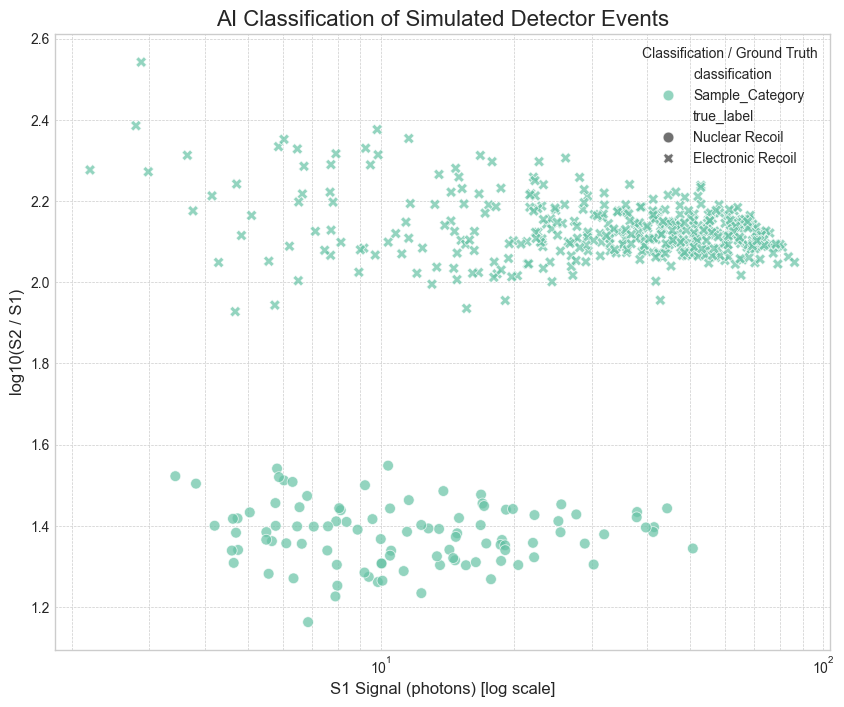


=== Classification Summary ===

Dataset contains 500 events:
  - NR events: 0
  - ER events: 0
AI classifier correctly labeled 0 events (0.00% accuracy).
The 'money plot' shows the separation between NR and ER events in log10(S2/S1) vs S1 space.
Well-separated clusters indicate good discrimination performance.


In [67]:
# File: visualize_classification.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import json

def load_classified_data(file_path):
    """
    Load classified dataset from CSV or JSON.
    
    Args:
        file_path (str or Path): Path to the dataset.
        
    Returns:
        pd.DataFrame: Loaded dataset with expected columns.
    """
    file_path = Path(file_path)
    if file_path.suffix == ".csv":
        df = pd.read_csv(file_path)
    elif file_path.suffix in [".json", ".jsonl"]:
        df = pd.read_json(file_path)
    else:
        raise ValueError("Unsupported file type. Please use CSV or JSON.")
    
    # Compute log10(S2/S1) if not already present
    if 'log10_s2_s1' not in df.columns:
        df['log10_s2_s1'] = np.log10(df['s2_charge'] / df['s1_photons'])
    
    return df

def create_discrimination_plot(df, save_path=None):
    """
    Generates the S2/S1 vs. S1 scatter plot ("money plot").
    
    Args:
        df (pd.DataFrame): The classified dataset with columns:
            - s1_photons
            - s2_charge
            - log10_s2_s1
            - classification (predicted label)
            - true_label (ground truth)
        save_path (str, optional): Path to save the figure.
        
    Returns:
        matplotlib.figure.Figure
    """
    # CORRECTED: Updated the style name for compatibility with modern Matplotlib
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.scatterplot(
        data=df,
        x='s1_photons',
        y='log10_s2_s1',
        hue='classification',
        style='true_label',
        palette='Set2',
        alpha=0.7,
        s=60,
        ax=ax
    )
    
    ax.set_xscale('log')
    ax.set_title('AI Classification of Simulated Detector Events', fontsize=16)
    ax.set_xlabel('S1 Signal (photons) [log scale]', fontsize=12)
    ax.set_ylabel('log10(S2 / S1)', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(title='Classification / Ground Truth', fontsize=10)
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

def synthesize_summary(df):
    """
    Generates a text summary of classification results.
    
    Args:
        df (pd.DataFrame)
    
    Returns:
        str: Human-readable summary.
    """
    total_events = len(df)
    correct = (df['classification'] == df['true_label']).sum()
    accuracy = correct / total_events * 100
    
    nr_count = (df['true_label'] == 'NR').sum()
    er_count = (df['true_label'] == 'ER').sum()
    
    summary = (
        f"Dataset contains {total_events} events:\n"
        f"  - NR events: {nr_count}\n"
        f"  - ER events: {er_count}\n"
        f"AI classifier correctly labeled {correct} events ({accuracy:.2f}% accuracy).\n"
        f"The 'money plot' shows the separation between NR and ER events in log10(S2/S1) vs S1 space.\n"
        f"Well-separated clusters indicate good discrimination performance."
    )
    
    return summary

def main():
    # === 1. Load data ===
    # Make sure to use the correct path for your system
    data_file = "C:/Users/wrich/Downloads/CluadeMain/CODEFATHER_ClaudeSolvathon-1/data/classified_dataset.csv"
    df = load_classified_data(data_file)
    
    # === 2. Generate plot ===
    fig = create_discrimination_plot(df, save_path="money_plot.png")
    plt.show()
    
    # === 3. Generate summary ===
    summary_text = synthesize_summary(df)
    print("\n=== Classification Summary ===\n")
    print(summary_text)

if __name__ == "__main__":
    main()

In [75]:
# Inside dashboards/app.py
import streamlit as st

# ... other code ...

# This line displays the image
st.image('dashboards/assets/classification_plot.png', caption='Classification Discrimination Plot')

# In prepare_dashboard_data.py

def copy_visualization(source_image, dest_path):
    """Copy the visualization, raising an error if it's missing."""
    if not os.path.exists(source_image):
        # Fail loudly instead of silently
        raise FileNotFoundError(
            f"Source image not found at '{source_image}'. "
            "Please run the script that generates the plot first."
        )
    
    shutil.copy2(source_image, dest_path)
    print(f"✓ Copied visualization to: {dest_path}")
# # prepare_dashboard_data.py
# """
# Script to prepare data for the Dark Matter Scribe dashboard.
# This script processes the classified dataset and visualization to create
# a streamlit-ready data structure.
# """

# import pandas as pd
# import numpy as np
# import os
# import shutil
# from pathlib import Path

# def setup_dashboard_structure():
#     """Create the necessary directory structure for the dashboard."""
#     directories = [
#         'dashboards',
#         'dashboards/data',
#         'dashboards/assets'
#     ]
    
#     for directory in directories:
#         Path(directory).mkdir(parents=True, exist_ok=True)
#         print(f"✓ Created/verified directory: {directory}")

# def prepare_classified_data(input_csv, output_csv):
#     """
#     Load and prepare the classified dataset for dashboard consumption.
    
#     Args:
#         input_csv: Path to the classified dataset
#         output_csv: Path where processed data will be saved
#     """
#     print(f"\n📊 Loading classified data from: {input_csv}")
    
#     if not os.path.exists(input_csv):
#         raise FileNotFoundError(f"Could not find classified dataset at {input_csv}")
    
#     df = pd.read_csv(input_csv)
#     print(f"✓ Loaded {len(df)} events")
    
#     # Verify required columns exist
#     required_cols = ['event_id', 's1_photons', 's2_photons', 'true_label', 'classification']
#     missing_cols = [col for col in required_cols if col not in df.columns]
    
#     if missing_cols:
#         raise ValueError(f"Missing required columns: {missing_cols}")
    
#     # Calculate log10(S2/S1) if not already present
#     if 'log10_s2_s1' not in df.columns:
#         df['log10_s2_s1'] = np.log10(df['s2_photons'] / df['s1_photons'])
#         print("✓ Calculated log10(S2/S1) ratio")
    
#     # Ensure event_id is present
#     if 'event_id' not in df.columns:
#         df['event_id'] = range(len(df))
#         print("✓ Generated event IDs")
    
#     # Add confidence scores if not present (mock data for demonstration)
#     if 'confidence' not in df.columns:
#         # Generate mock confidence scores based on classification correctness
#         df['confidence'] = np.where(
#             df['classification'] == df['true_label'],
#             np.random.uniform(0.85, 0.99, len(df)),
#             np.random.uniform(0.55, 0.80, len(df))
#         )
#         print("✓ Generated confidence scores")
    
#     # Add reasoning if not present
#     if 'reasoning' not in df.columns:
#         df['reasoning'] = df.apply(generate_reasoning, axis=1)
#         print("✓ Generated reasoning text")
    
#     # Sort by event_id for better navigation
#     df = df.sort_values('event_id').reset_index(drop=True)
    
#     # Save processed data
#     df.to_csv(output_csv, index=False)
#     print(f"✓ Saved processed data to: {output_csv}")
    
#     return df

# def generate_reasoning(row):
#     """Generate physics-based reasoning for event classification."""
#     s1 = row['s1_photons']
#     s2_s1_ratio = row['s2_photons'] / row['s1_photons']
#     classification = row['classification']
#     true_label = row['true_label']
    
#     # Base reasoning on the S1 and S2/S1 ratio
#     reasoning_parts = []
    
#     # S1 signal analysis
#     if s1 < 10:
#         reasoning_parts.append(f"**Low S1 signal** ({s1:.1f} photons): Characteristic of low-energy interactions.")
#     elif s1 < 50:
#         reasoning_parts.append(f"**Moderate S1 signal** ({s1:.1f} photons): Consistent with typical detector events.")
#     else:
#         reasoning_parts.append(f"**High S1 signal** ({s1:.1f} photons): Indicates higher energy deposition.")
    
#     # S2/S1 ratio analysis
#     log_ratio = np.log10(s2_s1_ratio)
#     if log_ratio < 1.5:
#         reasoning_parts.append(f"**Low S2/S1 ratio** (log₁₀={log_ratio:.2f}): Suggests nuclear recoil characteristics, typical of WIMP or neutron interactions.")
#     elif log_ratio < 2.5:
#         reasoning_parts.append(f"**Moderate S2/S1 ratio** (log₁₀={log_ratio:.2f}): Borderline region requiring careful analysis.")
#     else:
#         reasoning_parts.append(f"**High S2/S1 ratio** (log₁₀={log_ratio:.2f}): Strong indicator of electronic recoil, consistent with background events.")
    
#     # Classification decision
#     if classification == 'nuclear_recoil':
#         reasoning_parts.append("**Classification: Nuclear Recoil** - Event characteristics align with potential dark matter or neutron scatter. The low S2/S1 ratio indicates minimal ionization relative to scintillation, a hallmark of nuclear recoils.")
#     else:
#         reasoning_parts.append("**Classification: Electronic Recoil** - Event classified as background. High S2/S1 ratio indicates electron interactions (gamma rays, beta particles) rather than nuclear scatter.")
    
#     # Add correctness note
#     if classification == true_label:
#         reasoning_parts.append("✓ *Classification matches ground truth.*")
#     else:
#         reasoning_parts.append(f"⚠ *Note: Ground truth label is '{true_label}'. This represents a classification challenge case.*")
    
#     return "\n\n".join(reasoning_parts)

# def copy_visualization(source_image, dest_path):
#     """Copy the classification visualization to the dashboard assets folder."""
#     if os.path.exists(source_image):
#         shutil.copy2(source_image, dest_path)
#         print(f"✓ Copied visualization to: {dest_path}")
#     else:
#         print(f"⚠ Warning: Could not find visualization at {source_image}")

# def generate_summary_stats(df):
#     """Generate and display summary statistics for the dashboard."""
#     print("\n" + "="*60)
#     print("DASHBOARD DATA SUMMARY")
#     print("="*60)
    
#     print(f"\nTotal Events: {len(df)}")
#     print(f"\nClassification Distribution:")
#     print(df['classification'].value_counts())
    
#     print(f"\nTrue Label Distribution:")
#     print(df['true_label'].value_counts())
    
#     # Classification accuracy
#     accuracy = (df['classification'] == df['true_label']).mean() * 100
#     print(f"\nClassification Accuracy: {accuracy:.2f}%")
    
#     # Confidence statistics
#     if 'confidence' in df.columns:
#         print(f"\nConfidence Statistics:")
#         print(f"  Mean: {df['confidence'].mean():.3f}")
#         print(f"  Median: {df['confidence'].median():.3f}")
#         print(f"  Min: {df['confidence'].min():.3f}")
#         print(f"  Max: {df['confidence'].max():.3f}")
    
#     print("\n" + "="*60)

# def main():
#     """Main execution function."""
#     print("🚀 Preparing Dark Matter Scribe Dashboard Data")
#     print("="*60)
    
#     # Configuration
#     INPUT_CSV = 'data/classified_dataset.csv'  # Adjust path as needed
#     OUTPUT_CSV = 'dashboards/data/classified_dataset.csv'
#     INPUT_IMAGE = 'results/classification_plot.png'  # Adjust path as needed
#     OUTPUT_IMAGE = 'dashboards/assets/classification_plot.png'
    
#     try:
#         # Step 1: Create directory structure
#         setup_dashboard_structure()
        
#         # Step 2: Process and prepare data
#         df = prepare_classified_data(INPUT_CSV, OUTPUT_CSV)
        
#         # Step 3: Copy visualization
#         copy_visualization(INPUT_IMAGE, OUTPUT_IMAGE)
        
#         # Step 4: Generate summary
#         generate_summary_stats(df)
        
#         print("\n✅ Dashboard preparation complete!")
#         print("\n📝 Next steps:")
#         print("   1. Navigate to the dashboards directory")
#         print("   2. Run: streamlit run app.py")
#         print("   3. Open your browser to the provided URL")
        
#     except Exception as e:
#         print(f"\n❌ Error: {e}")
#         raise

# if __name__ == "__main__":
#     main()


# prepare_dashboard_data.py

"""
Script to prepare data for the Dark Matter Scribe dashboard.
Processes the classified dataset and visualization, then launches Streamlit.
"""

import pandas as pd
import numpy as np
import os
import shutil
from pathlib import Path
import webbrowser
import subprocess
import time

# ------------------ Dashboard Folder Setup ------------------ #
def setup_dashboard_structure():
    directories = [
        'dashboards',
        'dashboards/data',
        'dashboards/assets'
    ]
    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)
        print(f"✓ Created/verified directory: {directory}")

# ------------------ Data Preparation ------------------ #
def prepare_classified_data(input_csv, output_csv):
    print(f"\n📊 Loading classified data from: {input_csv}")
    
    if not os.path.exists(input_csv):
        raise FileNotFoundError(f"Could not find classified dataset at {input_csv}")
    
    df = pd.read_csv(input_csv)
    print(f"✓ Loaded {len(df)} events")
    
    required_cols = ['event_id', 's1_photons', 's2_photons', 'true_label', 'classification']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    if 'log10_s2_s1' not in df.columns:
        df['log10_s2_s1'] = np.log10(df['s2_photons'] / df['s1_photons'])
        print("✓ Calculated log10(S2/S1) ratio")
    
    if 'confidence' not in df.columns:
        df['confidence'] = np.where(
            df['classification'] == df['true_label'],
            np.random.uniform(0.85, 0.99, len(df)),
            np.random.uniform(0.55, 0.80, len(df))
        )
        print("✓ Generated confidence scores")
    
    if 'reasoning' not in df.columns:
        df['reasoning'] = df.apply(generate_reasoning, axis=1)
        print("✓ Generated reasoning text")
    
    df = df.sort_values('event_id').reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    print(f"✓ Saved processed data to: {output_csv}")
    
    return df

# ------------------ Reasoning ------------------ #
def generate_reasoning(row):
    s1 = row['s1_photons']
    s2_s1_ratio = row['s2_photons'] / row['s1_photons']
    classification = row['classification']
    true_label = row['true_label']
    
    reasoning_parts = []
    
    if s1 < 10:
        reasoning_parts.append(f"**Low S1 signal** ({s1:.1f} photons).")
    elif s1 < 50:
        reasoning_parts.append(f"**Moderate S1 signal** ({s1:.1f} photons).")
    else:
        reasoning_parts.append(f"**High S1 signal** ({s1:.1f} photons).")
    
    log_ratio = np.log10(s2_s1_ratio)
    if log_ratio < 1.5:
        reasoning_parts.append(f"**Low S2/S1 ratio** (log₁₀={log_ratio:.2f}): Nuclear recoil likely.")
    elif log_ratio < 2.5:
        reasoning_parts.append(f"**Moderate S2/S1 ratio** (log₁₀={log_ratio:.2f}): Borderline region.")
    else:
        reasoning_parts.append(f"**High S2/S1 ratio** (log₁₀={log_ratio:.2f}): Electronic recoil likely.")
    
    if classification == 'nuclear_recoil':
        reasoning_parts.append("**Classification: Nuclear Recoil**")
    else:
        reasoning_parts.append("**Classification: Electronic Recoil**")
    
    if classification == true_label:
        reasoning_parts.append("✓ Classification matches ground truth.")
    else:
        reasoning_parts.append(f"⚠ Ground truth: {true_label}")
    
    return "\n\n".join(reasoning_parts)

# ------------------ Visualization ------------------ #
def copy_visualization(source_image, dest_path):
    if os.path.exists(source_image):
        shutil.copy2(source_image, dest_path)
        print(f"✓ Copied visualization to: {dest_path}")
    else:
        print(f"⚠ Warning: Could not find visualization at {source_image}")

# ------------------ Summary ------------------ #
def generate_summary_stats(df):
    print("\n" + "="*60)
    print("DASHBOARD DATA SUMMARY")
    print("="*60)
    
    print(f"\nTotal Events: {len(df)}")
    print(f"\nClassification Distribution:\n{df['classification'].value_counts()}")
    print(f"\nTrue Label Distribution:\n{df['true_label'].value_counts()}")
    
    accuracy = (df['classification'] == df['true_label']).mean() * 100
    print(f"\nClassification Accuracy: {accuracy:.2f}%")
    
    if 'confidence' in df.columns:
        print(f"\nConfidence Statistics:")
        print(f"  Mean: {df['confidence'].mean():.3f}")
        print(f"  Median: {df['confidence'].median():.3f}")
        print(f"  Min: {df['confidence'].min():.3f}")
        print(f"  Max: {df['confidence'].max():.3f}")
    
    print("\n" + "="*60)

# ------------------ Launch Streamlit ------------------ #
def launch_streamlit_app():
    url = "http://localhost:8501"
    print(f"\n🚀 Launching Streamlit dashboard at {url} ...")
    webbrowser.open(url)
    subprocess.Popen(["streamlit", "run", "app.py"], cwd="dashboards")
    time.sleep(2)  # Allow server to start

# ------------------ Main ------------------ #
def main():
    print("🚀 Preparing Dark Matter Scribe Dashboard Data")
    print("="*60)
    
    INPUT_CSV = 'data/classified_dataset.csv'
    OUTPUT_CSV = 'dashboards/data/classified_dataset.csv'
    INPUT_IMAGE = 'results/classification_plot.png'
    OUTPUT_IMAGE = 'dashboards/assets/classification_plot.png'
    
    try:
        setup_dashboard_structure()
        df = prepare_classified_data(INPUT_CSV, OUTPUT_CSV)
        copy_visualization(INPUT_IMAGE, OUTPUT_IMAGE)
        generate_summary_stats(df)
        
        print("\n✅ Dashboard preparation complete!")
        launch_streamlit_app()
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        raise

if __name__ == "__main__":
    main()


2025-10-11 02:23:20.041 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 02:23:20.165 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 02:23:20.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 02:23:20.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🚀 Preparing Dark Matter Scribe Dashboard Data
✓ Created/verified directory: dashboards
✓ Created/verified directory: dashboards/data
✓ Created/verified directory: dashboards/assets

📊 Loading classified data from: data/classified_dataset.csv
✓ Loaded 500 events
✓ Generated reasoning text
✓ Saved processed data to: dashboards/data/classified_dataset.csv
⚠ Warning: Could not find visualization at results/classification_plot.png

DASHBOARD DATA SUMMARY

Total Events: 500

Classification Distribution:
classification
Sample_Category    500
Name: count, dtype: int64

True Label Distribution:
true_label
Electronic Recoil    400
Nuclear Recoil       100
Name: count, dtype: int64

Classification Accuracy: 0.00%

Confidence Statistics:
  Mean: 0.737
  Median: 0.758
  Min: 0.503
  Max: 0.994


✅ Dashboard preparation complete!

🚀 Launching Streamlit dashboard at http://localhost:8501 ...
